# [Graph-Attention Augmented Temporal Neural Network Build for Diagnosis](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9134772)


## DATA EXPLORATION

In [1]:
import datetime
import time
import pickle
from tqdm.notebook import tqdm

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
plt.rcParams["figure.figsize"] = (20,12)

# Main computation libraries
import numpy as np
from itertools import combinations
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Deep learning related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device= 'cpu'

In [3]:
df = pd.read_csv('data.csv')

In [4]:
# datetime formatting and conversion
df['diag_drug_date'] =  pd.to_datetime(df['diag_drug_date'], format='%Y-%m-%d')
df['death_date'] =  pd.to_datetime(df['death_date'], format='%Y-%m-%d')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246844 entries, 0 to 1246843
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   personid        1246844 non-null  int64         
 1   diag_drug_code  1246844 non-null  object        
 2   diag_drug_date  1246844 non-null  datetime64[ns]
 3   death_date      412929 non-null   datetime64[ns]
 4   target          1246844 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 47.6+ MB


In [6]:
df.shape

(1246844, 5)

In [7]:
df.head()

,personid,diag_drug_code,diag_drug_date,death_date,target
0,5603,Diseases of the circulatory system,2001-02-02,NaT,0
1,4878,DIABETES,2012-09-04,2013-03-01,1
2,3001,MH,2017-07-24,NaT,0
3,3308,83,2008-10-11,NaT,0
4,1497,Diseases of the circulatory system,2016-03-15,NaT,0


In [8]:
print("No of Unique patients:",len(df.personid.unique()))

No of Unique patients: 6398


## DATA PREPROCESSING
1. Last week of data before death_date and any data after death_date need to be removed for patient whose target==1 

2. Most recent encounter needs to be within 12 months before death date for patient whose target==1 or before the last diagnosis for patient whose target==0.Patients not meeting this criterion need to be removed. 

3. Remove rows with num codes as drug codes from data since we will be using daignosis only.(comment line in cell 12 to include this)



In [9]:
# getting all the death dates of patients with suicide ==1 for computations

ids = list(df.personid.unique())
mapping = dict()
for idd in ids:
    date = df[df.personid ==idd]['death_date'].iloc[0]
    if df[df.personid ==idd].iloc[0].target == 0:
        mapping[idd] = False
    else:
        mapping[idd] = date

## mapping

1. As mentioned in the below notebook cell , I choose to use only diagnosis and not medical codes since I didn't find that data to change anything of the model and the challenge asked only for diagnosis.
2. But The code will work for medical codes too and I have mentioned that one can comment the line mentioned in below cell while preprocessing to consider medicines also.
3. But the training process will take time since there would be around 120 nodes in the graphs with over 1 lacs data point with batch size 1.


In [11]:
# cleaning records which doesnt qualify the above mentioned criterias
records =[]
for patient_id in mapping.keys():
    if mapping[patient_id]:
        temp_df = df[df.personid ==patient_id].sort_values(by = 'diag_drug_date')
        temp_df = temp_df[temp_df.diag_drug_date < mapping[patient_id]]
        temp_df = temp_df[temp_df.diag_drug_date < pd.to_datetime((mapping[patient_id]- datetime.timedelta(days=7)).date())]
        temp_df = temp_df[temp_df.diag_drug_code.str.isdigit()!= True] # comment this to include medicines
        if len(temp_df) > 0 and (temp_df.sort_values(by = 'diag_drug_date').iloc[-1]['diag_drug_date'] > (mapping[patient_id]- pd.DateOffset(months=12))):
            records.extend(list(temp_df.T.to_dict().values()))
    else:
        temp_df = df[df.personid ==patient_id].sort_values(by = 'diag_drug_date')
        temp_df = temp_df[temp_df.diag_drug_code.str.isdigit()!= True] # comment this to include medicines
        if len(temp_df) >= 2 and (temp_df.sort_values(by = 'diag_drug_date').iloc[-1]['diag_drug_date'] < (temp_df.sort_values(by = 'diag_drug_date').iloc[-2]['diag_drug_date'] + pd.DateOffset(months=12))):
            records.extend(list(temp_df.T.to_dict().values()))
            
cleaned_df = pd.DataFrame(records)
cleaned_data = cleaned_df.copy()
cleaned_df.shape

(569505, 5)

In [12]:
print("No of patients after preprocesing: ",len(cleaned_df.personid.unique()))

print("No of records deleted: ",df.shape[0] - cleaned_df.shape[0])

print("No of patients deleted: ",len(df.personid.unique()) - len(cleaned_df.personid.unique()))

No of patients after preprocesing:  6033
No of records deleted:  677339
No of patients deleted:  365


## Global Guidance Correlation Graph

We First need to construct a global guidance correlation graph G, where each node is a clinical event code.
Edges are based on co-occurrence probability between events in each admission of every patient used for guidance.


In [13]:
# getting the list of all patients
patients = list(cleaned_data.personid.unique())
EHRs = []

In [15]:
# getting the EHRs fro each patient record
for patient in patients:
    temp =  cleaned_data[cleaned_data.personid == patient] # get a specific patient EHRs
    diagnosis_group = dict(temp.groupby("diag_drug_date").groups) # groupy by addmisisons so events of that admission is fetched
    for key,values in diagnosis_group.items():
        temp = []
        for value in values:
            temp.append(cleaned_data.iloc[value]['diag_drug_code'])
        EHRs.append(sorted(temp))

In [17]:
# the total number of diagnosis events in the dataset
diagnosis = sorted(list(set(cleaned_data.diag_drug_code.to_list())))
N = len(diagnosis) # no of nodes in the graph

In [19]:
# diagnosis

# calculating correlation count between pairs of diagnosis events
correcation_val = [[0 for i in range(N)] for j in range(N)]
for pair in EHRs:
    dig_pairs = list(combinations(pair, 2))
    for dig in dig_pairs:
        correcation_val[diagnosis.index(dig[0])][diagnosis.index(dig[1])]+=1

# number of admission records that an event have appeared at least once
diagnosis_count = {key:0 for key in diagnosis}
for pair in EHRs:
    for dig in pair:
        diagnosis_count[dig]+=1

In [20]:
diagnosis_count

{'ADULT MALTREATMENT': 21,
 'AF': 25760,
 'BIP': 6723,
 'CHILD MALTREATMENT': 26,
 'COPD': 15014,
 'DIABETES': 79531,
 'Diseases of the circulatory system': 148983,
 'Epilepsy and recurrent seizures': 2763,
 'MB': 8158,
 'MDD': 20622,
 'MH': 83055,
 'Migraine': 3661,
 'Overweight and obesity': 6463,
 'Overweight, obesity and other hyperalimentation': 6480,
 'PD': 797,
 'SLE': 642,
 'SUD': 12965,
 'Suicidal attempt': 1650,
 'anxiety': 17679,
 'asthma': 8797,
 'bipolar spectrum illness': 10764,
 'depression': 33500,
 'eating': 1465,
 'pain': 53078,
 'psychosis': 3975,
 'schizophrenia': 2048,
 'sleep': 13856,
 'suicidal ideation': 1029}

<img src="files/global.png"/>

In [21]:
# Point-wise Mutual Information (PMI) value to calculate the weight of the edges
def pmi(i,j):
    pmi_val = np.log((correcation_val[i][j]/(diagnosis_count[diagnosis[i]]*diagnosis_count[diagnosis[j]]))*cleaned_data.shape[0])
    if pmi_val>0:
        return pmi_val
    else:
        return 0
    
def cal_m(i,j):
    pmi_val = pmi(i,j)
    if pmi_val>0:
        return pmi_val
    else:
        return 0

In [23]:
# Calculating the global adjency matrix M
M = [[0 for i in range(N)] for j in range(N)]
for i in range(N):
    for j in range(N):
        M[i][j] = cal_m(i,j)

# adjanecy Matrix of G
# M[0]

/var/folders/kj/vfyygflx2ngbnynwj9sfgnsc0000gn/T/ipykernel_18472/3149818180.py:3: RuntimeWarning: divide by zero encountered in log
  pmi_val = np.log((correcation_val[i][j]/(diagnosis_count[diagnosis[i]]*diagnosis_count[diagnosis[j]]))*cleaned_data.shape[0])


In [24]:
labels = {key:value for key,value in enumerate(diagnosis)}

In [26]:
def adjacency_list_dict(adj_mat):
    '''returns a edge adjemcy list'''
    adjacency_list_dict = {}
    for index, mi in enumerate(adj_mat):
        adjacency_list_dict[index] =[]
        for ind,m in enumerate(mi):
            if m != 0:
                adjacency_list_dict[index].append(ind)
    results = {}
    for key,value in adjacency_list_dict.items():
        if value:
            results[key]=value
    return results

In [27]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    '''returns a edge list for a given grapg adjency matrix'''
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

In [28]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment its out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node out-degree distribution for dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

In [35]:
num_of_nodes = N
adjacency_list = adjacency_list_dict(M)
edge_index_global  = build_edge_index(adjacency_list, num_of_nodes, add_self_edges=False)

/var/folders/kj/vfyygflx2ngbnynwj9sfgnsc0000gn/T/ipykernel_18472/1205508416.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  in_degrees = np.zeros(num_of_nodes, dtype=np.int)
/var/folders/kj/vfyygflx2ngbnynwj9sfgnsc0000gn/T/ipykernel_18472/1205508416.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

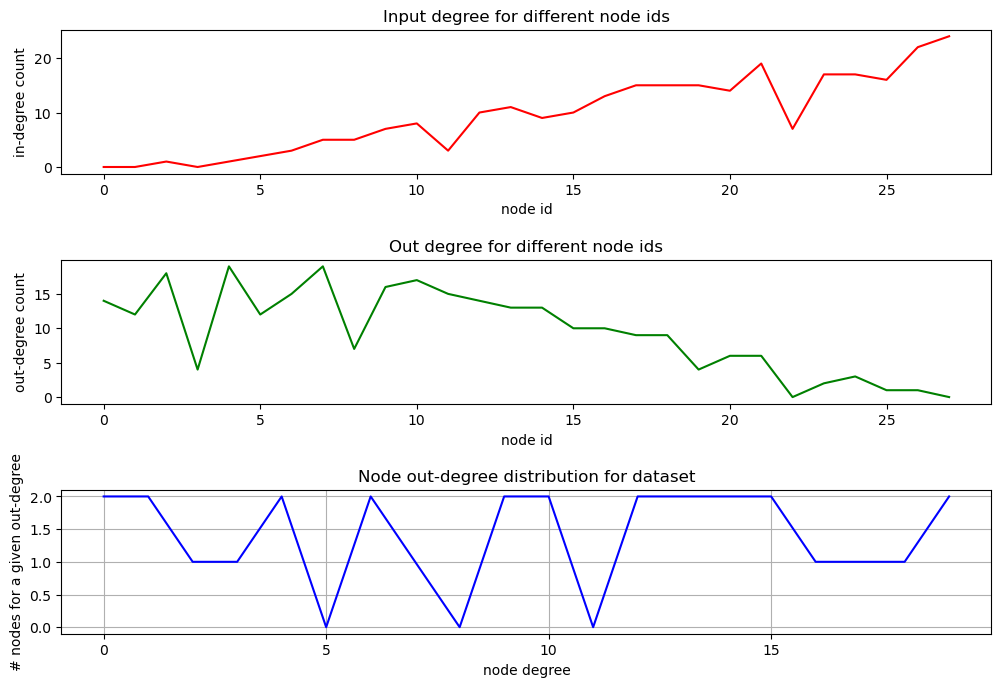

In [36]:
plot_in_out_degree_distributions(edge_index_global, num_of_nodes)

### Plot Global Graph From M

<img src="files/global2.png"/>

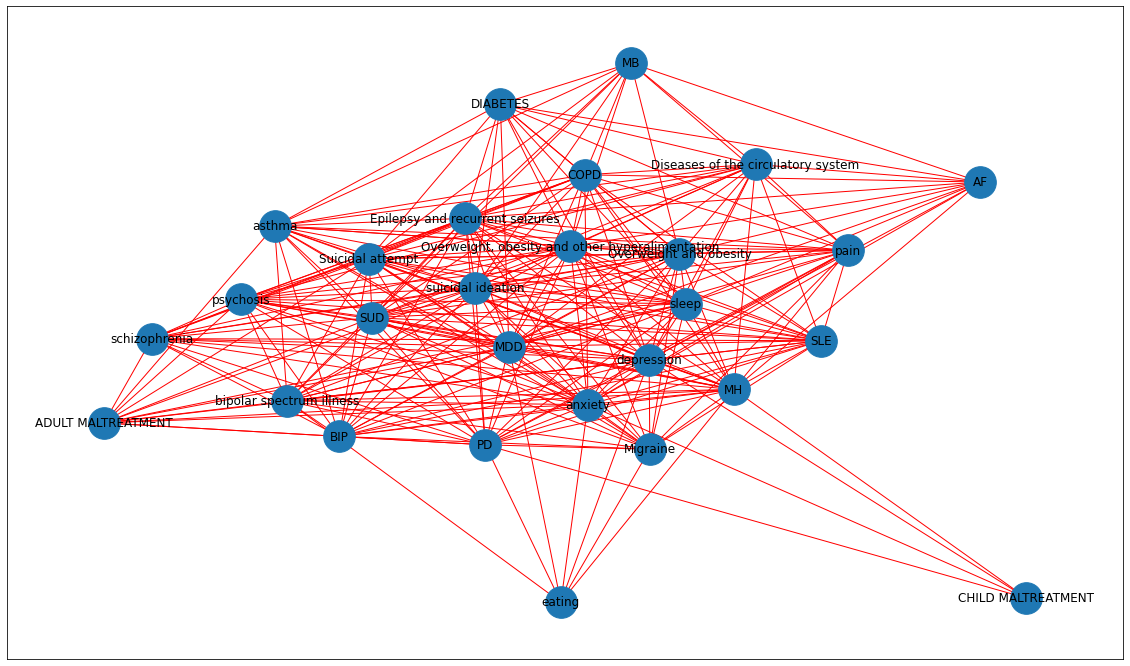

In [52]:
def plot_graph(edge_index,node_label):
    edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :]))  
    nx_graph = nx.Graph()
    nx_graph.add_edges_from(edge_index_tuples)
    
    nx.draw_networkx(nx_graph,node_size=1000,labels = node_label, edge_color = 'red',font_color = 'black',with_labels=True)
    
    plt.show()
    
plot_graph(edge_index_global,labels)

## Local mapping of the global guidance co-occurrence graph

Dynamic co-occurrence graphs from each patient's history admission sequences

In [53]:
dataset = {}

diagnosis_pairs = list(combinations(diagnosis, 2))

Creating local graphs A for each patients each admission at time t

<img src="files/local1.png"/>

In [54]:
for patient in patients:
    At= []
    temp =  cleaned_data[cleaned_data.personid ==patient]
    diagnosis_group = dict(temp.groupby("diag_drug_date").groups)
    A =  [[0 for i in range(N)] for j in range(N)]
    for key,values in diagnosis_group.items():
        temp = []
        for value in values:
            temp.append(cleaned_data.iloc[value]['diag_drug_code'])
        for x in diagnosis_pairs:
            i = diagnosis.index(x[0])
            j = diagnosis.index(x[1])
            if x[0] in temp and x[1] in temp:
                A[i][j] = M[i][j]
        At.append(A)
                
    dataset[patient] =At

In [55]:
# containts each patients dynamic co-occurrence graphs for each point of admission
patients = list(dataset.keys())
len(dataset)

6033

Plot Local graph A

<img src="files/local2.png"/>

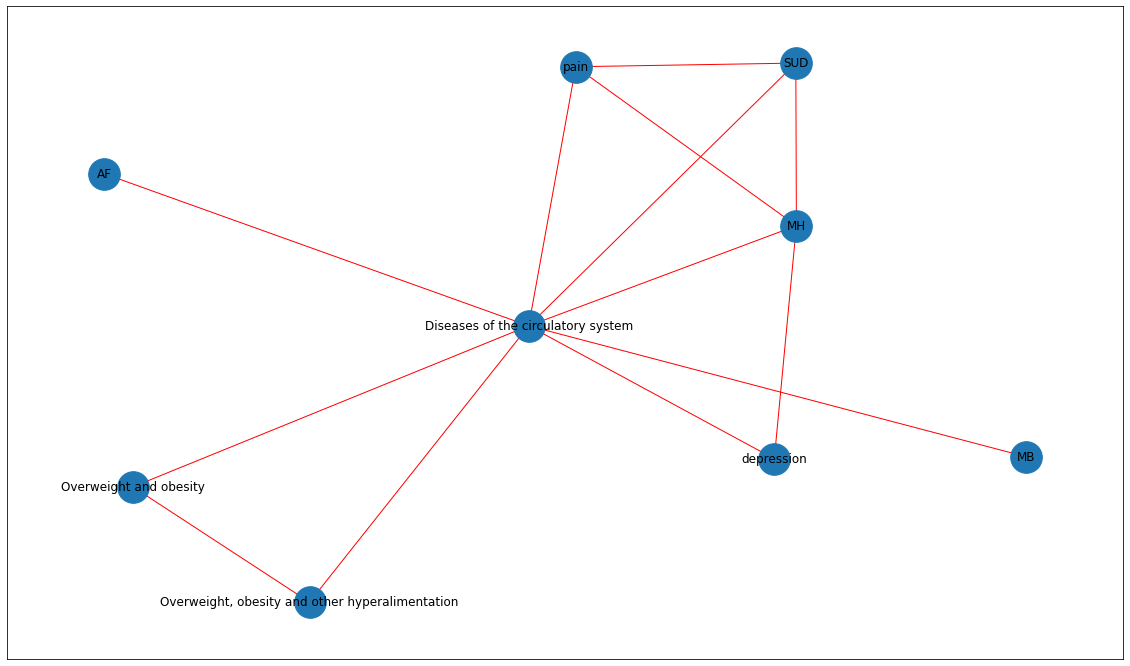

In [56]:
patient_ind = 5603
admission_ind = 3

patient_no_with_admission_ind = dataset[patient_ind][admission_ind]

adjacency_list = adjacency_list_dict(patient_no_with_admission_ind)
edge_index_local  = build_edge_index(adjacency_list, num_of_nodes=len(adjacency_list), add_self_edges=False)
nodel_labels = {}

for key ,value in adjacency_list.items():
    if key not in nodel_labels:
        nodel_labels[key] = labels[key]
    for val in value:
        if val not in nodel_labels:
            nodel_labels[val] = labels[val]

plot_graph(edge_index_local,nodel_labels)

# Utilites

In [57]:
# multi-hot vector representation to Transform clinical codes to vectors
mlb = MultiLabelBinarizer()
mlb.fit([diagnosis])
mlb.classes_

array(['ADULT MALTREATMENT', 'AF', 'BIP', 'CHILD MALTREATMENT', 'COPD',
       'DIABETES', 'Diseases of the circulatory system',
       'Epilepsy and recurrent seizures', 'MB', 'MDD', 'MH', 'Migraine',
       'Overweight and obesity',
       'Overweight, obesity and other hyperalimentation', 'PD', 'SLE',
       'SUD', 'Suicidal attempt', 'anxiety', 'asthma',
       'bipolar spectrum illness', 'depression', 'eating', 'pain',
       'psychosis', 'schizophrenia', 'sleep', 'suicidal ideation'],
      dtype=object)

In [58]:
def get_patient_diagnosis(patient):
    '''returns patients diagnosis history at each point of time'''
    patient_diags= []
    temp =  cleaned_data[cleaned_data.personid ==patient]
    diagnosis_group = dict(temp.groupby("diag_drug_date").groups)
    for key,values in diagnosis_group.items():
        temp = []
        for value in values:
            temp.append(cleaned_data.iloc[value]['diag_drug_code'])
        patient_diags.append(temp)
    return patient_diags

In [59]:
def get_feature_matrix(patient_diag):
    '''Calculates embedding matrix ct'''
    ct = list(mlb.transform([patient_diag]))
    return ct

# Creating Training Dataset

As asked in the challenge Description -You must predict diagnosis, and do so upon the earliest possible visit. For example, if a patient in the training set visits twice, and is diagnosed with a new condition the second time, your algorithm's goal is to predict that diagnosis the first visit. 

For Doing this i consider input for the model being the current diagnosis feature matrix and the local Graph A at that paticular admission for a  patient and the target being the not seen daignosis in the next visit.

I create a dataset with the above logic for each patient where create a dataframe which contains - 
    1. The patient id - column - patient_id
    2. The diagnosis feature matrix at that admission time t - column - ct
    3. The target node index in the graph which being the next not seen daignosis. - column - target
    4. The admission index of the patient from its complete EHR - column - A_index

In [60]:
# creating the training dataset
diagnosis_code_mapping = {value:key for key, value in enumerate(diagnosis)}
training_dataset = []
for patient_id in tqdm(patients):
    patient_diags = get_patient_diagnosis(patient_id)
    already_seen =[]
    for i,patient_diag in enumerate(patient_diags):
        for daig in patient_diag:
            if daig not in already_seen:
                training_dataset.append(
                    {
                        'patient_id':patient_id, 
                        'ct':get_feature_matrix(patient_diag),
                        'target':diagnosis_code_mapping[daig],
                        'A_index':i
                    })
                already_seen.append(daig)

# no of records
len(training_dataset)

  0%|          | 0/6033 [00:00<?, ?it/s]

36948

In [61]:
admission_history =  pd.DataFrame(training_dataset)

# the dataframe created as stated above
admission_history.head()

,patient_id,ct,target,A_index
0,5603,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",6,0
1,5603,"[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",23,3
2,5603,"[[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",1,3
3,5603,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,...",10,14
4,5603,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,...",16,16


In [62]:
class Data(object):
    ''' A Data class fro pytorch dataloader'''
    def __init__(self, edge_lists, features, labels):
        self.edge_lists = edge_lists
        self.features = features
        self.labels = labels
        self.num_classes = len(labels)

    def __len__(self):
         return len(self.labels)
        
    def __getitem__(self, index):
        edge_lists = self.edge_lists[index]
        features = self.features[index]
        labels = self.labels[index]

        return edge_lists,features, labels

In [63]:
def load_data(dataframe):
    '''Loads all the required data from the dataframe rows and returns a Data object'''
    features = []
    labels = []
    edge_lists=[]
    for ind, row in dataframe.iterrows():
        feature = row['ct']
        label = row['target']
        adjacency_list = adjacency_list_dict(dataset[row['patient_id']][row['A_index']])
        edge_list  = build_edge_index(adjacency_list, num_of_nodes=num_of_nodes, add_self_edges=True)
        features.append(feature)
        labels.append(label)
        edge_lists.append(edge_list)

    data = Data(edge_lists, features,labels)

    return data

torch_data = load_data(admission_history)

I am using batch_size 1 since pytorch restricts inputs of differnet shapes and the A matrix for all the rows in the dataframe will have different shapes depeding on the daignosis event involved.

If one wnats to use batch_size all this A matrix must be made to have same shapes with padding.

In [64]:
batch_size = 1 
validation_split = .15
shuffle_dataset = True
random_seed= 42

In [65]:
# Creating data indices for training and validation splits:
dataset_size = len(torch_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(torch_data, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(torch_data, batch_size=batch_size,
                                                sampler=valid_sampler)

# Train & Test Split
len(train_loader),len(validation_loader)

(31406, 5542)

## MODEL FRAMEWORK

According to the paper - 
    - the initial embedding size and hidden size of GRU to 64. 
    - For the 2-layer GAM module, the hidden layer dimension of 
    - the first layer is set to 128, and
    - the second layer is set to 64. 
    - The dropout rate is set to 0.2.

### Input embedding module (EMB)

<img src="files/model2.png"/>

In [66]:
class EMBLayer(nn.Module):
    def __init__(self,N=28,d=64):
        '''d is embedding feature dimension
        ct is a multi-hot vector representing the existence of each clinical event at the t-th admission '''
        super(EMBLayer, self).__init__()
        self.We = nn.Parameter(torch.FloatTensor(N,d))
        self.reset_parameters()

    def reset_parameters(self):
        '''uniform distribution intialisation'''
        nn.init.xavier_uniform_(self.We, gain=1.5)
        
    def forward(self, x):
        '''returns a feature matrix of shape (len(x),d)'''
        H0 = self.We * torch.transpose(x[0],-1,0)
        return H0

### GRAPH-ATTENTION AUGMENTED MODULE (GAM)

<img src="files/local3.png"/>

In [67]:
class GAMLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, bias=True):
        super(GAMLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        
        # intialising weights w and attention a and  bias b as stated in equation-6
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        '''uniform distribution intialisation'''
        nn.init.xavier_uniform_(self.weight.data, gain=1.414)
        if self.bias is not None:
            self.bias.data.fill_(1)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, x, edge_list):
        '''returns node representation of every event code at the l-th graph'''
        x = F.dropout(x, self.dropout, training=self.training)
        h = torch.matmul(x, self.weight)
        
        # concating neginbouring nodes from gievn A's edge list
        source, target = edge_list
        source, target = source.long(), target.long() 
        a_input = torch.cat([h[source], h[target]], dim=1) 
        e = F.leaky_relu(torch.matmul(a_input, self.a))
        
        # calculating the attention coefficient
        N = h.size(0)
        attention = torch.ones([N, N], device=device)
        attention[source, target] = e[:, 0]
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        
        
        # calcuating eqaution -5 for forward propagation 
        h = F.dropout(h, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)
        if self.bias is not None:
            h_prime = h_prime + self.bias
       
        return F.elu(h_prime)

### TEMPORAL DEPENDENCY UPDATING MODULE (TDU)

<img src="files/model4.png">


In [68]:
class TDULayer(nn.Module):
    def __init__(self, input_size, hidden_size=64, bias=True):
        '''hidden size of this layer as mentioned is 64'''
        super(TDULayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        #set up all the operations that are needed in the forward pass
        self.w_r = torch.nn.Linear(input_size, input_size, bias=True)
        self.w_z = torch.nn.Linear(hidden_size, hidden_size, bias = True)
        self.w = torch.nn.Linear(hidden_size, hidden_size, bias = True)
        self.h2h = torch.nn.Linear(hidden_size, hidden_size, bias=bias)
        
        
    def reset_parameters(self):
        '''uniform distribution intialisation'''
        for w in self.parameters():
            nn.init.xavier_uniform_(w.data, gain=1.414)
    
    def forward(self, x, hidden):
        '''return the node representations of temporal characteristics f_cap'''
        x = x.view(-1, x.size(0))
        
        # calculating gate values using equation 9
        R = F.sigmoid((self.w_r(x) + self.w_r(hidden)))
        Z = F.sigmoid((self.w_z(x) + self.w_z(hidden)))
        f_tilde = F.tanh((self.w(R) + self.w(x) + self.w(hidden)))
        f = ((1-Z) * hidden) + (Z * f_tilde)
        
        # calculating the final vvalue using eq - 8
        f_cap = self.h2h(hidden) + ((1-self.h2h(hidden))*f)
        return f_cap

### Creating the Final Model framework

<!-- <img src="files/model1.png"> -->
<img src="files/model1.png"/>

### MULTI-INSTANCE MULTI-LABEL CLASSIFICATION

<!-- <img src="files/model5.png"/> -->
![](files/model5.PNG)

In [69]:
class GATE(nn.Module):
    def __init__(self, input_dim =28, hidden_dim = 64, gru_layer_dim=2, num_classes = 1):
        '''input_dim : the no of nodes in the global graph or total unique event codes in the datatset
           hidden_dim : as mentioned in the paper is 64
           gru_layer_dim : as mentioned in the paper is a  2 layer GRU Cell
           num_classes : or no of output class - since we are only predicting  the enxt daignosis we have 1 as the value.
        '''
        super(GATE, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = EMBLayer(input_dim) # EMB layer takes the input of feature matrix ct shape (28,1)
        self.gaml1 = GAMLayer(64, 128) # GAM layer 1 with input dim 64 and hidden dim 128
        self.gaml2 = GAMLayer(128,64) # GAM layer 1 with input dim 64 and hidden dim 64
        self.tdu = TDULayer(64,64,gru_layer_dim) # 2D GRU cell TDU layer with input dim 64 and hidden dim 64
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2) # maxpool layer as mentioned in the paper
        self.fc = nn.Linear(64,num_classes,bias = True) # a fc layer for scoring matrix eq-10
        self.relu = nn.LeakyReLU() # a Relu layer for scoring matrix eq-10
        
    def forward(self, x, edge_list):
        '''x is the ct-(feature matrix) and edge_list is the A's graph at time t for a given patient'''
        
        # get medical embedding for a feature matrix
        x = self.embedding(x)  
        
        # get node representation with 2 layer gam network
        x = self.gaml1(x,edge_list)
        x1 = self.gaml2(x,edge_list)
        
        # for each node representation calculate the temporal correlation
        h0 = Variable(torch.zeros(1, x1.size(0), self.hidden_dim))
        outs = []
        
        hn = h0[0,:,:]
        
        # I pass it for five iteration updates since doing for each layer was resulting in gradient explosion
        # one can configure and play with this 
        for seq in range(5):
            hn = self.tdu(x1[seq,:], hn) 
            outs.append(hn)
            
        # select the node features contained in the last admission record from the output of TDU module
        x2 = outs[-1].squeeze()
        
        # temporal characteristics from TDU is then concatenate structural encoding from GAM to create feature bag O
        x = torch.cat([x1, x2], dim=1).unsqueeze(dim=0)
        
        # A max-pooling operation on this 2D instance-label scoring matrix
        x = self.maxpool(x)
       
        # fully connected layer in which the matching score sij of the i-th clinical event instance is calculated
        logit = self.fc(self.relu(x)).squeeze()
        
        # adding an epslion value to output for reducing gradient explosion and softmax
        logit += 1e-5
        
        # our final prediction Y of size 1*N. 
        return torch.reshape(logit,(1,N))

# Model Training

<img src="files/model6.png"/>

In [70]:
# during evaluation pleasechange this to a small number like 5 so that it doesn't takes much time
n_epochs = 30
# instantiate a model
model = GATE(input_dim = N).to(device)
# define loss fucntion
loss_fn = nn.CrossEntropyLoss()
# setup otimizer wth learning rate lr and L2 regularization parameter weight_decay
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-4, weight_decay=1e-5)

### Training Algorithm

<img src="files/model7.png"/>

1. As mentioned in the jupyter notebook the training algorithm is the same described in the paper where the diagnosis is passes through the different layers mentioned in the papaer which in our case is the GATE Model's forward pass which in turn calls that layers forward pass for computation. And the rest of loss calculation and back propagation is same as one do in any model training. Both the optimizer and loss function are as mentioned in the paper.
2. I take all the admission records of the patient at all time steps and then create a dataset by taking one diagnosis vector at a given time t for a patient and then take the other diagnosis vector for the same patient at time step t+1 and check for any new unseen diagnosis and if found one that becomes our target diagnosis node in the graph for that daignosis at time step t as asked in the challenge to predict diagnosis for a patient at the earliest


In [71]:
train_loss = []
valid_loss = []
test_y = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for ind,(edge_list, feature, label) in enumerate(train_loader):
        
        # Forward Pass
        optimizer.zero_grad()
        
        # Model Prediction
        y_pred = model(feature,edge_list[0])
        
        # Compute loss
        loss = loss_fn(y_pred, label)
        
        # Backward Pass
        loss.backward()
        
        # Gradient Cliping
        torch.nn.utils.clip_grad_value_(model.parameters(),10)

        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    
    for ind,(edge_list, feature, label) in enumerate(validation_loader):
        y_pred = model(feature,edge_list[0]).detach()
        avg_val_loss += loss_fn(y_pred, label).item() / len(validation_loader)
        
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))

/Users/skj/miniforge3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/skj/miniforge3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1/30 	 loss=3.2359 	 val_loss=3.0066 	 time=103.17s
Epoch 2/30 	 loss=3.1215 	 val_loss=2.9754 	 time=101.31s
Epoch 3/30 	 loss=3.0911 	 val_loss=2.9098 	 time=101.15s
Epoch 4/30 	 loss=3.0635 	 val_loss=2.8879 	 time=101.15s
Epoch 5/30 	 loss=3.0584 	 val_loss=2.8684 	 time=101.07s
Epoch 6/30 	 loss=3.0409 	 val_loss=2.8758 	 time=101.66s
Epoch 7/30 	 loss=3.0336 	 val_loss=2.8428 	 time=103.56s
Epoch 8/30 	 loss=3.0289 	 val_loss=2.8166 	 time=102.09s
Epoch 9/30 	 loss=3.0197 	 val_loss=2.8332 	 time=101.77s
Epoch 10/30 	 loss=3.0170 	 val_loss=2.7988 	 time=101.30s
Epoch 11/30 	 loss=3.0017 	 val_loss=2.7779 	 time=102.99s
Epoch 12/30 	 loss=3.0013 	 val_loss=2.8037 	 time=102.87s
Epoch 13/30 	 loss=2.9992 	 val_loss=2.7817 	 time=103.63s
Epoch 14/30 	 loss=3.0014 	 val_loss=2.7920 	 time=104.15s
Epoch 15/30 	 loss=2.9945 	 val_loss=2.7761 	 time=104.03s
Epoch 16/30 	 loss=2.9954 	 val_loss=2.7717 	 time=105.23s
Epoch 17/30 	 loss=2.9938 	 val_loss=2.7611 	 time=103.92s
Epoch 

In [72]:
# save the model and its state
torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')

In [74]:
# loading model
model = GATE()
checkpoint = torch.load('trained_model/checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [75]:
# I did just  a baisc accuracy test to check if I can compute Metrics.
# As descrived in the papaers its would be better to use othe metrics described for evaluation
val_preds = np.zeros((len(validation_loader),len(mlb.classes_)))
count = 0
y_preds= []
y_lables = []
for ind,(edge_list, feature, label) in tqdm(enumerate(validation_loader)):
    y_pred = model(feature,edge_list[0]).detach()
    y_pred = int(y_pred.argmax(axis=1))
    y = int(label[0])
    y_preds.append(y_pred)
    y_lables.append(y)
    if y_pred == y:
        count+=1
print("Model Accuracy ",count/len(validation_loader))

0it [00:00, ?it/s]

Model Accuracy  0.12215806568025983


In [76]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_lables, y_preds)
print("Node \t precision \t recall \t fscore \t support")
for i,dat in enumerate(zip(precision,recall,fscore,support)):
    print('{} \t {:.4f} \t {:.4f} \t {:.4f} \t {:.4f}'.format(i,dat[0],dat[1],dat[2],dat[3]))

Node 	 precision 	 recall 	 fscore 	 support
0 	 0.0211 	 1.0000 	 0.0412 	 2.0000
1 	 0.1639 	 0.4255 	 0.2367 	 141.0000
2 	 0.1405 	 0.5600 	 0.2246 	 75.0000
3 	 0.0000 	 0.0000 	 0.0000 	 1.0000
4 	 0.1465 	 0.3444 	 0.2055 	 151.0000
5 	 0.1349 	 0.1501 	 0.1421 	 353.0000
6 	 0.1151 	 0.1304 	 0.1222 	 767.0000
7 	 0.0694 	 0.2273 	 0.1064 	 44.0000
8 	 0.2258 	 0.1134 	 0.1509 	 247.0000
9 	 0.1591 	 0.3584 	 0.2204 	 226.0000
10 	 0.1880 	 0.1865 	 0.1873 	 654.0000
11 	 0.0734 	 0.0988 	 0.0842 	 81.0000
12 	 0.1361 	 0.1143 	 0.1242 	 175.0000
13 	 0.0333 	 0.0215 	 0.0261 	 186.0000
14 	 0.0000 	 0.0000 	 0.0000 	 24.0000
15 	 0.0256 	 0.1429 	 0.0435 	 14.0000
16 	 0.1074 	 0.0528 	 0.0708 	 246.0000
17 	 0.0000 	 0.0000 	 0.0000 	 50.0000
18 	 0.0917 	 0.0379 	 0.0536 	 264.0000
19 	 0.1308 	 0.0800 	 0.0993 	 175.0000
20 	 0.0323 	 0.0323 	 0.0323 	 93.0000
21 	 0.0761 	 0.0161 	 0.0266 	 435.0000
22 	 0.0135 	 0.1429 	 0.0247 	 7.0000
23 	 0.3077 	 0.0474 	 0.0822 	 675

In [78]:
from sklearn.metrics import f1_score
f1_score(y_lables, y_preds,average='weighted')

0.11004687965546534

In [79]:
import scipy.spatial.distance as dist
dist.pdist([y_lables,y_preds], 'jaccard')[0]

0.878158844765343

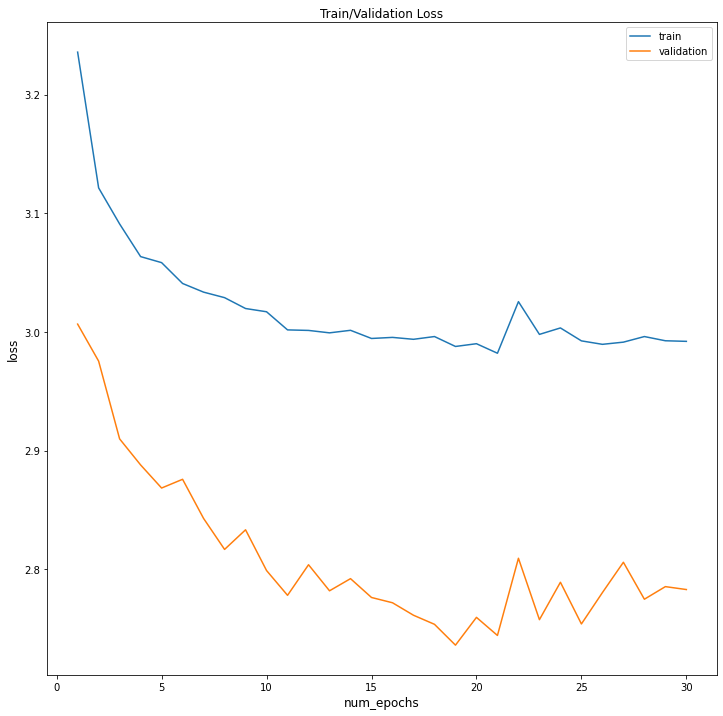

In [80]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    
plot_graph(n_epochs)

In [81]:
def predict_single(feature,edge_list,mlb):  
    ''' returns a prediction for new input'''
    pred = model(feature,edge_list[0]).detach()
    
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = mlb.classes_[pred]
    
    return pred[0]

In [82]:
# predicting for a single patient admission
patient_id = 165
patient_admissions = get_patient_diagnosis(patient_id)

# taking a paticular admission of the patient
admission_index = 6

# fetching diagnossi at that admission
patient_diag = patient_admissions[admission_index]

print("Diagnosis at time t: ",patient_diag)
# get feature vector of daignosis against all daignosis events
feature = get_feature_matrix(patient_diag)

# creating a local coreelation edge matrix
adjacency_list = adjacency_list_dict(dataset[patient_id][admission_index])
edge_list  = build_edge_index(adjacency_list, num_of_nodes=num_of_nodes, add_self_edges=True)

# predicting the diagnosis
pred = predict_single([torch.tensor(feature,dtype=torch.long)],[torch.tensor(edge_list,dtype=torch.long)],mlb)

print("Diagnosis at time t+1: ",pred)

Diagnosis at time t:  ['Diseases of the circulatory system']
Diagnosis at time t+1:  DIABETES


/var/folders/kj/vfyygflx2ngbnynwj9sfgnsc0000gn/T/ipykernel_18472/302888664.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  pred = predict_single([torch.tensor(feature,dtype=torch.long)],[torch.tensor(edge_list,dtype=torch.long)],mlb)
/Users/skj/miniforge3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/skj/miniforge3/envs/ml/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/var/folders/kj/vfyygflx2ngbnynwj9

In [83]:
# Top events that are most correlated to suicidal death

labels

{0: 'ADULT MALTREATMENT',
 1: 'AF',
 2: 'BIP',
 3: 'CHILD MALTREATMENT',
 4: 'COPD',
 5: 'DIABETES',
 6: 'Diseases of the circulatory system',
 7: 'Epilepsy and recurrent seizures',
 8: 'MB',
 9: 'MDD',
 10: 'MH',
 11: 'Migraine',
 12: 'Overweight and obesity',
 13: 'Overweight, obesity and other hyperalimentation',
 14: 'PD',
 15: 'SLE',
 16: 'SUD',
 17: 'Suicidal attempt',
 18: 'anxiety',
 19: 'asthma',
 20: 'bipolar spectrum illness',
 21: 'depression',
 22: 'eating',
 23: 'pain',
 24: 'psychosis',
 25: 'schizophrenia',
 26: 'sleep',
 27: 'suicidal ideation'}

The Global Graph G's Adjency Matrix M, as described in the paper it is equivalent to the attention vector in equation-6 and is used to create the correlation graph below


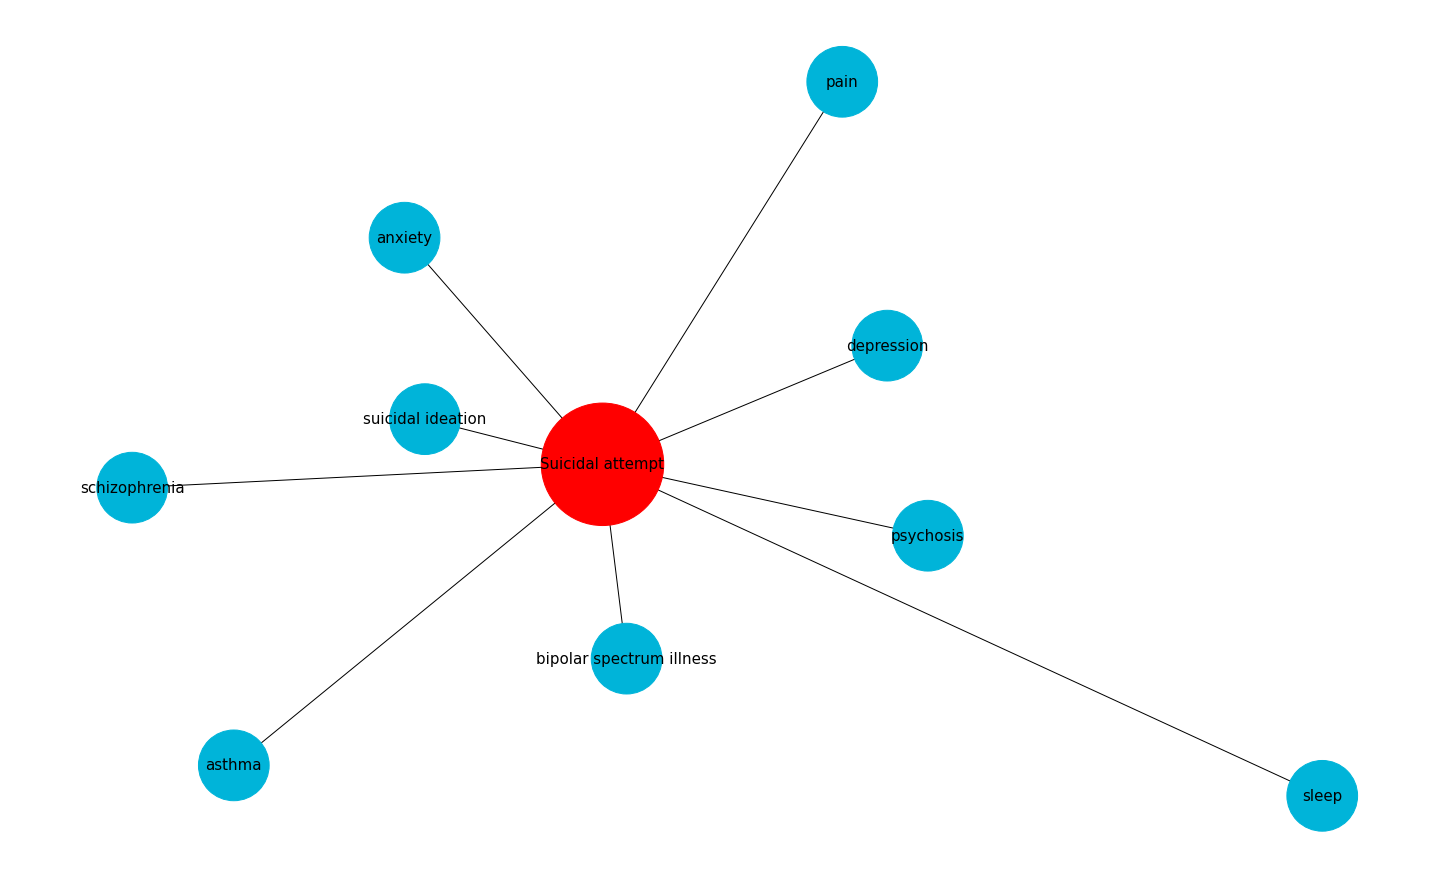

In [84]:
num_of_nodes = N

disease_ind = 17 # sucide node - replace with any other daignosis ind from above dict

adjacency_list = {labels[disease_ind]:[]}
edge_weights= []
for ind,i in enumerate(M[disease_ind]):
    if i!=0:
        adjacency_list[labels[disease_ind]].append(labels[ind])
        edge_weights.append(i)
        
new_edge_weights = [ int(x*10) for x in edge_weights]
                       
edge_index  = build_edge_index(adjacency_list, num_of_nodes, add_self_edges=False)

edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :])) 


lengths = []
for e,l in zip(edge_index_tuples, new_edge_weights):
    lengths.append((e[0],e[1],l))

lengths = sorted(lengths, key=lambda x: x[2])[:10]


G = nx.Graph()


node_sizes = [15000]
for i in range(len(lengths)):
    node_sizes.append(5000)
    
node_color = ["red"]
for i in range(len(lengths)):
    node_color.append("#00b4d9")


G.add_weighted_edges_from(lengths)

nx.draw(G, node_size=node_sizes, node_color=node_color, with_labels=True,font_size=15)